# Import

In [1]:
from qDrift.hamsimqDrift import AlgorithmHamSimqDrift
from pytket.circuit import Circuit
from openfermion.utils.operator_utils import count_qubits

from utils.func import *
from utils.term_grouping import *
from utils.min_clique import *
from utils.hamlib import *
from utils.evol_real import *
from utils.plot import *
from utils.driver import *
from utils.JW import *

import numpy as np
import matplotlib.pyplot as plt

def gen_sys_param(n=10, sample_steps=100000, N=1):
    global t_max
    global initial_state_circ
    global n_qdrift_steps
    global sample_space
    global seg

    t_max=2
    seg = N
    initial_state_circ = Circuit(n)
    for i in range(n):
        initial_state_circ.H(i)
    n_qdrift_steps = sample_steps
    sample_space = np.arange(0,sample_steps+1,1)

# Hydrogen chain

In [2]:
driver = PySCFDriver_custom()
bond_length = 1.0
n_sites = 3
driver.load_molecule(
    atom=[('H', (0, 0, i * bond_length)) for i in range(n_sites)], # Create a molecular data object for the hydrogen chain
    basis="sto-3g",          # Basis set for quantum chemistry calculation
    multiplicity=1,          # Spin multiplicity for molecule, since the total spin of H2O is S=0，its spin multiplicity is 2S+1=1
    charge=0,                 # Total charge of molecule, since H2O is charge neutral, its charge=0
    unit="Angstrom"
)
driver.run_scf()             # Perform Hartree Fock calculation

# np.set_printoptions(precision=4, linewidth=150)

hpq = driver.get_onebody_tensor("int1e_kin") + driver.get_onebody_tensor("int1e_nuc")
vpqrs = driver.get_twobody_tensor()
# assert np.shape(hpq)==(7, 7)             # H2O has 7 orbitals when using STO-3G basis.
# assert np.shape(vpqrs)==(7, 7, 7, 7)

# print(hpq)
operator = get_molecular_hamiltonian(hpq,vpqrs,driver)
n_qubits = count_qubits(operator)
number, coulomb, hopping, no_excitation, double_excitation = JW_transformation(operator)
numbers, coulombs, hoppings, no_excitations, double_excitations = JW_transformation(operator,True)

number_op, number_co = convert_op_to_input(number,n_qubits)
hopping_op, hopping_co = convert_op_to_input(hopping,n_qubits)
coulomb_op, coulomb_co = convert_op_to_input(coulomb,n_qubits)
no_excitation_op, no_excitation_co = convert_op_to_input(no_excitation,n_qubits)
double_excitation_op, double_excitation_co = convert_op_to_input(double_excitation,n_qubits)

numbers_op, numbers_co = convert_op_to_input(numbers,n_qubits,True)
hoppings_op, hoppings_co = convert_twobody_op_to_input(hoppings,n_qubits,True)
coulombs_op, coulombs_co = convert_op_to_input(list(coulombs),n_qubits,True)
no_excitations_op, no_excitations_co = convert_twobody_op_to_input(list(no_excitations),n_qubits,True)
no_excitations_op = [[x[0],x[2]] for x in no_excitations_op] + [[x[1],x[3]] for x in no_excitations_op]
no_excitations_co = [[x[0],x[2]] for x in no_excitations_co] + [[x[1],x[3]] for x in no_excitations_co]
double_excitations_op, double_excitations_co = convert_twobody_op_to_input(list(double_excitations),n_qubits,True)

# max_part_group = [[number_op[0], number_op[-2],hopping_op[0], hopping_op[1]],number_op[2:4],[number_op[1], number_op[-1], hopping_op[-2],hopping_op[-1]]]+coulombs_op+no_excitations_op+double_excitations_op
# max_coeff = [[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4],[number_co[2]],[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4]]+coulombs_co+no_excitations_co+double_excitations_co
# max_part_group, max_coeff = site_excitation_group(numbers_op,hoppings_op,numbers_co,hoppings_co)

H_matrix = get_Hmatrix(number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,n_qubits,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co)

converged SCF energy = -1.52399620024611


In [3]:
gen_sys_param(n=n_qubits,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg,H_matrix=H_matrix)
p2p,secdepth = drift_time_evolution.trotter(order=2, protected=True,spectral=False,measurement='H',cheat=True)

In [4]:
gen_sys_param(n=n_qubits,sample_steps=200)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps, seg,H_matrix=H_matrix)
pt,ldepth = drift_time_evolution.trotter(spectral=False,measurement='H',cheat=True)

In [5]:
gen_sys_param(n=n_qubits,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps, seg,H_matrix=H_matrix)
p2,secdepth = drift_time_evolution.trotter(order=2,spectral=False,measurement='H',cheat=True)

In [6]:
gen_sys_param(n=n_qubits, sample_steps=secdepth[-1])
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,numbers_op+hoppings_op+coulombs_op+no_excitations_op+double_excitations_op,numbers_co+hoppings_co+coulombs_co+no_excitations_co+double_excitations_co,t_max,n_qdrift_steps,seg,H_matrix=H_matrix)
pm,sm,mdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1],spectral=False,measurement='H',cheat=True)

In [7]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op],[[c] for c in number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co],t_max,n_qdrift_steps,seg,H_matrix=H_matrix)
pq,sq,qdepth = drift_time_evolution_parity.Drift_exp(depth=secdepth[-1],spectral=False,measurement='H',cheat=True)

In [8]:
P = [np.array(p2p).flatten(),np.array(pt).flatten(),np.array(p2).flatten(),np.array(pm).flatten(),np.array(pq).flatten()]
depth = [secdepth,ldepth,secdepth,mdepth[0][0],qdepth[0][0]]
labels = ['second protected','lie','second','physDrift','qDrift'] 

/usr/local/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'number of pauli gadgets')

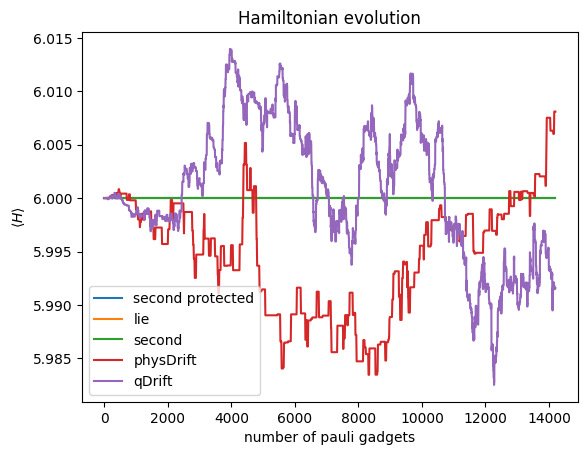

In [9]:
for i in range(len(P)):
    plt.plot(depth[i],P[i],label=labels[i])
plt.legend()
plt.title('Hamiltonian evolution')
plt.ylabel(r'$\langle H \rangle$')
plt.xlabel('number of pauli gadgets')